**Introduction to Autoencoders:**<br>
Autoencoders are a type of artificial neural network used for unsupervised learning, dimensionality reduction, and feature learning. They belong to the broader family of neural networks and are particularly popular in the field of deep learning. Autoencoders are designed to encode input data into a compact representation and then reconstruct the input data from this representation. The primary goal is to learn a useful and efficient representation of the input data.<br>

Here's a breakdown of the key components and concepts associated with autoencoders:<br>

**Encoder**: The encoder is the first half of the autoencoder. It takes the input data and transforms it into a reduced-dimensional representation. This process involves compressing the input information into a concise set of features.<br>

**Decoder**: The decoder is the second half of the autoencoder. It takes the reduced-dimensional representation created by the encoder and reconstructs the input data as closely as possible. The aim is to generate an output that is a meaningful reconstruction of the original input.

Here, we are gonna build autoencoder model using convolutional ,pooling and transpose convloutional layers and apply it on Galaxy-10 dataset and training the model to get minimum reconstruction loss.



In [1]:
import torch
import numpy as np

In [2]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####DATASET PREPARETION

In [4]:
label_dataset=np.load('/content/drive/MyDrive/Datasets/labels1.npy' ,mmap_mode='r')
images_dataset=np.load('/content/drive/MyDrive/Datasets/images1.npy' ,mmap_mode='r')


image_dataset = np.empty((len(images_dataset), 68, 68, 3))

for i in range(len(image_dataset)):
    image_dataset[i] = images_dataset[i, 1:, 1:, :]
    image_dataset[i]=image_dataset[i]/255.0

image_dataset = np.transpose(image_dataset, (0,3, 1, 2))

images=torch.from_numpy(image_dataset)
labels=torch.from_numpy(label_dataset)

dataset=torch.utils.data.TensorDataset(images,labels)

split_index = int(0.80 * len(images))
train_data, test_data = torch.utils.data.random_split(dataset, [split_index, len(dataset) - split_index])




trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                              shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                             shuffle=False, num_workers=0)

<ipython-input-4-54179345cb64>:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  labels=torch.from_numpy(label_dataset)


In [5]:
image_dataset.shape

(21785, 3, 68, 68)

####IMAGE PLOTTING

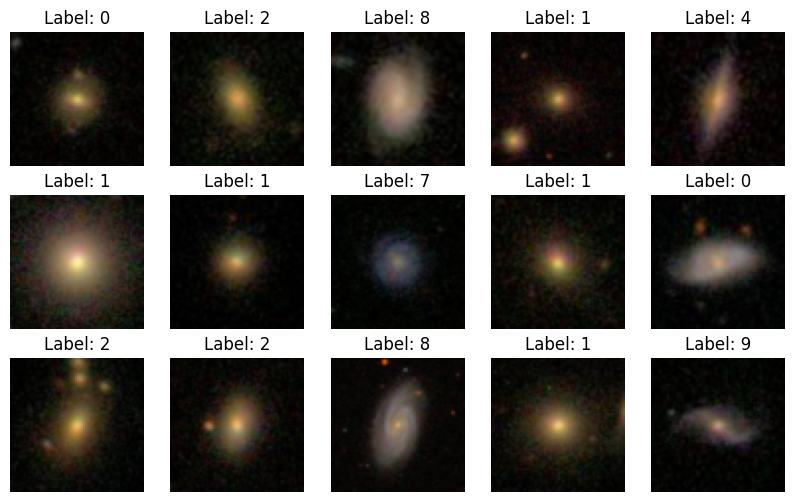

In [6]:
import matplotlib.pyplot as plt
import random
import numpy as np

random.seed(56)
num_cols=5
num_rows=3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
for i in range(num_cols*num_rows):
  img,label=train_data[random.randint(0,len(train_data))]
  row = i // num_cols
  col = i % num_cols
  axes[row, col].imshow(np.transpose(img, (1, 2, 0)))
  axes[row, col].set_title(f"Label: {label}")
  axes[row, col].axis('off')

####MODEL ARCHITECTURE

In [7]:
import torch.nn as nn

class autoEncoders(nn.Module):
  def __init__(self):
    super(autoEncoders, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),#(32*32*3)->(32*32*32)
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),#(32*32*64)->(16*16*64)
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),#(16*16*128)->(8*8*128)
        )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, output_padding=0),  # (8*8*128) -> (16*16*128)
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # (16*16*128) -> (16*16*64)
        nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, output_padding=0),  # (16*16*64) -> (32*32*64)
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # (32*32*64) -> (32*32*32)
        nn.ReLU(),
        nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),  # (32*32*32) -> (32*32*3)
        nn.Sigmoid()
        )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [8]:
model =autoEncoders().to(device)
model

autoEncoders(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

####MODEL PARAMETERS

In [9]:
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [10]:
from torch.autograd import Variable
def get_torch_vars(x):
  if torch.cuda.is_available():
        x = x.cuda()
  return Variable(x)


for epoch in range(20):
  model.train()
  running_loss = []
  for i, (inputs, _) in enumerate(trainloader, 0):
    inputs = get_torch_vars(inputs)
    inputs=inputs.to(torch.float)
    encoded, outputs = model(inputs)
    loss = loss_func(outputs, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss.append(loss.data.item())
  print('[epoch: %d] loss: %.5f ' % (epoch + 1, sum(running_loss) / len(running_loss)))

[epoch: 1] loss: 0.25599 
[epoch: 2] loss: 0.23898 
[epoch: 3] loss: 0.23841 
[epoch: 4] loss: 0.23810 
[epoch: 5] loss: 0.23792 
[epoch: 6] loss: 0.23780 
[epoch: 7] loss: 0.23763 
[epoch: 8] loss: 0.23762 
[epoch: 9] loss: 0.23745 
[epoch: 10] loss: 0.23731 
[epoch: 11] loss: 0.23724 
[epoch: 12] loss: 0.23712 
[epoch: 13] loss: 0.23714 
[epoch: 14] loss: 0.23698 
[epoch: 15] loss: 0.23695 
[epoch: 16] loss: 0.23686 
[epoch: 17] loss: 0.23689 
[epoch: 18] loss: 0.23671 
[epoch: 19] loss: 0.23684 
[epoch: 20] loss: 0.23675 


In [11]:
torch.cuda.empty_cache()

####TESTING MODEL

In [14]:
import matplotlib.pyplot as plt
import numpy as np


num_images = 5

actual_images = []
output_images = []
test_loss=[]
for i, (inputs, label) in enumerate(testloader, 0):
    inputs = get_torch_vars(inputs)
    inputs = inputs.to(torch.float)
    encoded, test_out = model(inputs)
    loss = loss_func(inputs, test_out)
    test_loss.append(loss.data)
    if i < num_images:
        actual_images.append(inputs.cpu().data)
        output_images.append(test_out.cpu().data)

print('loss: %.5f' % (sum(test_loss) / len(test_loss)))


loss: 0.24236


####PLOTTING RESULTS

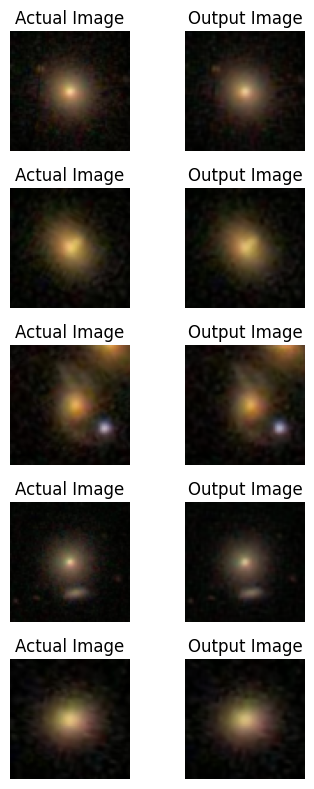

In [15]:
def im_convert(tensor):
    image = tensor.numpy().squeeze()
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = image.transpose(1, 2, 0)
    return image

fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(4, 8))

for idx in range(num_images):
    ax = axes[idx, 0]
    ax.imshow(im_convert(actual_images[0][idx]), cmap='gray' if actual_images[idx].shape[1] == 1 else None)
    ax.set_title("Actual Image")
    ax.axis('off')

    ax = axes[idx, 1]
    ax.imshow(im_convert(output_images[0][idx]), cmap='gray' if output_images[idx].shape[1] == 1 else None)
    ax.set_title("Output Image")
    ax.axis('off')

plt.tight_layout()
plt.show()

**Applications of Auto Encoders:**<br>
Autoencoders find diverse applications across various domains due to their ability to learn efficient data representations. Some notable applications include:


1.  **Data Compression**:
Autoencoders are used for compressing data into a compact representation while retaining essential features. This is particularly valuable in scenarios where storage or bandwidth is limited, such as image and video compression.
2.  **Anomaly Detection**:
By learning the normal patterns in data during the training phase, autoencoders can effectively identify anomalies or outliers when presented with new data. This makes them useful for detecting unusual patterns in various fields, including cybersecurity and fault detection.
3. **Image Denoising**:
Autoencoders can be trained to reconstruct clean images from noisy or corrupted inputs. This is beneficial in applications where images are degraded by noise or imperfections, such as medical imaging or surveillance.
<br>
etc.
<br><br>
They are also many other uses with autoencoders like domain expanison, and they are variations of autoencoders which are used also used as generative models like VAE (Variational autoencoders).

